In [3]:
import pandas as pd
import numpy as np

# ML
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Explicabilidad
import shap

# Visualización
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 1. Carga de datos
df = pd.read_csv(
    "data_kill_rd.csv", 
    parse_dates={"date": ["Fecha Infracción", "Hora Infracción"]},
    keep_date_col=True
)

# 2. Creación del Dataset Diario con Agregación Espacial
df_daily = (
    df
    .groupby([
        "Distrito", 
        pd.Grouper(key="date", freq="D")
    ])
    .agg(
        crime_count=("Distrito", "size"),          # Cuenta los delitos
        lat_mean=("Coord. Y Rev", "mean"),         # Promedio de Latitud del día
        lon_mean=("Coord. X Rev", "mean")          # Promedio de Longitud del día
    )
    .reset_index()
)

# 3. Orden espaciotemporal
df_daily = df_daily.sort_values(["Distrito", "date"])

# 4. Lags criminales (memoria)
for lag in [1, 2, 3]:
    df_daily[f"crime_lag_{lag}"] = df_daily.groupby("Distrito")["crime_count"].shift(lag)

# 5. Limpieza final
df_daily = df_daily.dropna()

C:\Users\migue\AppData\Local\Temp\ipykernel_3080\1323805900.py:4: FutureWarning: The 'keep_date_col' keyword in pd.read_csv is deprecated and will be removed in a future version. Explicitly remove unwanted columns after parsing instead.
  df = pd.read_csv(
C:\Users\migue\AppData\Local\Temp\ipykernel_3080\1323805900.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


In [3]:
def ingarch_intensity(y, alpha=0.4, beta=0.5, omega=0.1):
    """
    Intensidad condicional INGARCH(1,1)
    """
    lam = np.zeros(len(y))
    lam[0] = np.mean(y)

    for t in range(1, len(y)):
        lam[t] = omega + alpha * y[t-1] + beta * lam[t-1]

    return lam

In [4]:
df_daily["lambda_ingarch"] = (
    df_daily.groupby("Distrito")["crime_count"]
      .transform(lambda x: ingarch_intensity(x.values))
)

In [5]:
df_daily["day"] = df_daily["date"].dt.day
df_daily["month"] = df_daily["date"].dt.month

In [6]:
features = [
    "lambda_ingarch",
    "crime_lag_1",
    "crime_lag_2",
    "crime_lag_3",
    "lat_mean",
    "lon_mean",
    "day",
    "month"
]

X = df_daily[features]
y = df_daily["crime_count"]

model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="count:poisson",
    random_state=42
)

model.fit(X, y)

,objective,'count:poisson'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


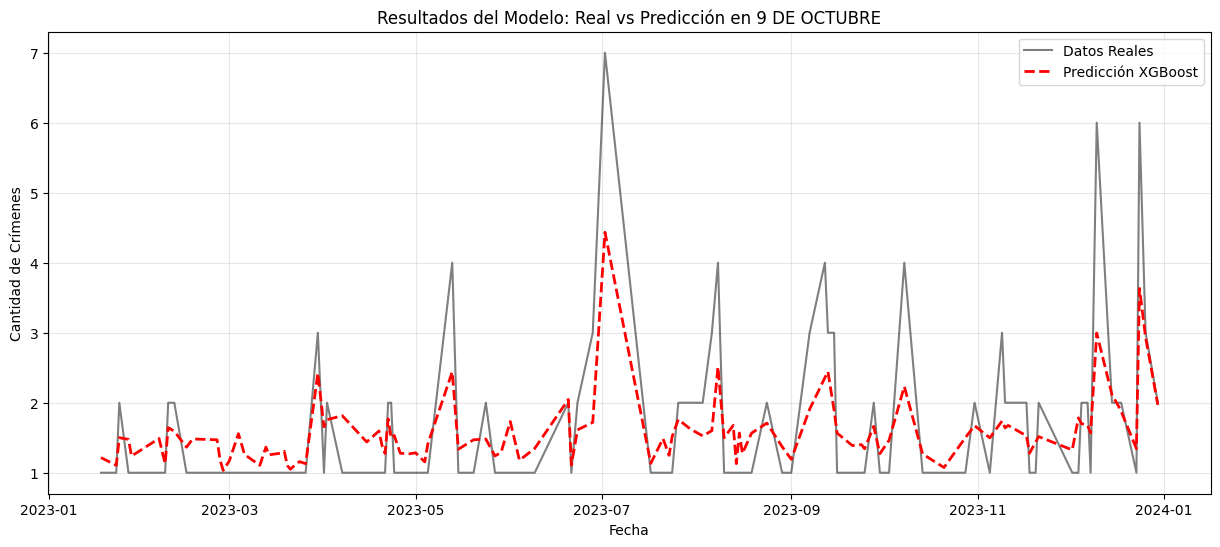

<Figure size 1000x600 with 0 Axes>

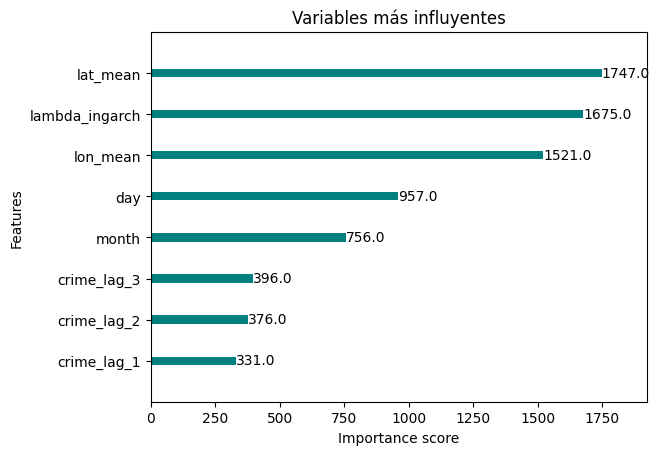

In [7]:
import matplotlib.pyplot as plt
# 1. Generar predicciones sobre los datos
# Nota: Lo ideal es hacer esto en un set de prueba, pero aquí visualizaremos lo aprendido.
df_daily["prediction"] = model.predict(X)

# 2. Gráfico 1: Real vs Predicho (Serie de Tiempo)
# Filtramos un solo distrito para que la gráfica se entienda (cambia el nombre si prefieres otro)
distrito_ejemplo = df_daily["Distrito"].unique()[0] 
subset = df_daily[df_daily["Distrito"] == distrito_ejemplo]

plt.figure(figsize=(15, 6))
plt.plot(subset["date"], subset["crime_count"], label="Datos Reales", color="black", alpha=0.5)
plt.plot(subset["date"], subset["prediction"], label="Predicción XGBoost", color="red", linestyle="--", linewidth=2)

plt.title(f"Resultados del Modelo: Real vs Predicción en {distrito_ejemplo}")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Crímenes")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Gráfico 2: Importancia de las Variables (Feature Importance)
# Esto te dirá qué variable tiene más peso en la predicción
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type="weight", title="Variables más influyentes", color="teal", grid=False)
plt.show()

In [15]:
def predict_risk(model, lambda_ingarch, lag1, lag2, lag3, 
                 lat_mean, lon_mean, day, month):
    
    X_new = pd.DataFrame([{
        "lambda_ingarch": lambda_ingarch,
        "crime_lag_1": lag1,
        "crime_lag_2": lag2,
        "crime_lag_3": lag3,
        "lat_mean": lat_mean,
        "lon_mean": lon_mean,
        "day": day,
        "month": month
    }])
    
    return model.predict(X_new)[0]

In [ ]:
risk = predict_risk(
    model,
    lambda_ingarch=4.2,
    lag1=7,
    lag2=1,
    lag3=1,
    lat_mean=-2.124255,
    lon_mean=-79.92073500000001,
    day=2,
    month=7
)

print("Riesgo esperado de delito:", risk)

Riesgo esperado de delito: 1.2019961


100%|===================| 1292/1293 [00:16<00:00]        

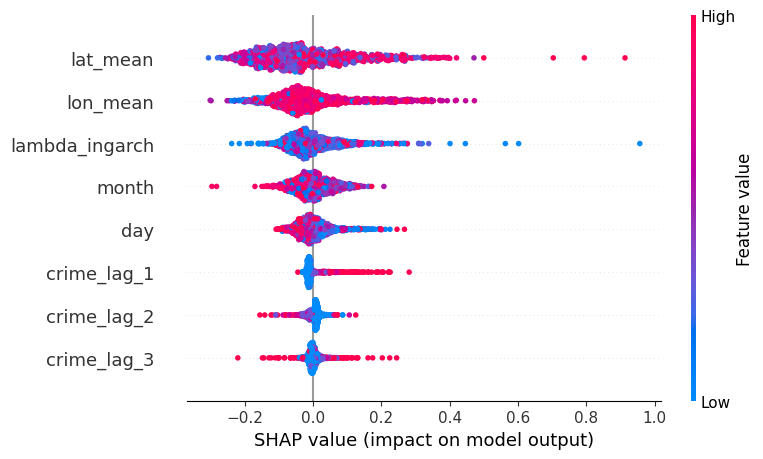

In [18]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Importancia global
shap.summary_plot(shap_values, X)

In [24]:
import pandas as pd
from scipy.stats import poisson

def predict_risk_advanced(model, lambda_ingarch, lag1, lag2, lag3, lat, lon, day, month):
    # 1. Crear el DataFrame con los inputs
    X_new = pd.DataFrame([{
        "lambda_ingarch": lambda_ingarch,
        "crime_lag_1": lag1,
        "crime_lag_2": lag2,
        "crime_lag_3": lag3,
        "lat_mean": lat,
        "lon_mean": lon,
        "day": day,
        "month": month
    }])
    
    # 2. Obtener el Valor Esperado (lambda) del modelo
    expected_count = model.predict(X_new)[0]
    
    # 3. Calcular PROBABILIDADES (La parte valiosa para tu tesis)
    # Probabilidad de que haya CERO crímenes (Seguridad total)
    prob_safety = poisson.pmf(0, expected_count)
    
    # Probabilidad de ALTO RIESGO (más de 3 crímenes)
    # 1 menos la probabilidad acumulada de 3
    prob_danger = 1 - poisson.cdf(3, expected_count)
    
    return {
        "prediccion_conteo": round(expected_count, 4),
        "probabilidad_calma_total": round(prob_safety * 100, 2), # %
        "probabilidad_alto_riesgo": round(prob_danger * 100, 2), # % (>3 delitos)
        "nivel_alerta": "ROJA" if prob_danger > 0.15 else "AMARILLA" if prob_danger > 0.05 else "VERDE"
    }

# --- EJECUCIÓN ---
reporte = predict_risk_advanced(
    model,
    lambda_ingarch=4.2,
    lag1=5,
    lag2=3,
    lag3=2,
    lat=-2.124255,
    lon=-79.920735,
    day=2,
    month=7
)

print(f"--- REPORTE DE INTELIGENCIA PREDICTIVA ---")
print(f"Crímenes esperados: {reporte['prediccion_conteo']}")
print(f"Probabilidad de >3 delitos hoy: {reporte['probabilidad_alto_riesgo']}%")
print(f"Nivel de Alerta: {reporte['nivel_alerta']}")

--- REPORTE DE INTELIGENCIA PREDICTIVA ---
Crímenes esperados: 1.3866000175476074
Probabilidad de >3 delitos hoy: 5.22%
Nivel de Alerta: AMARILLA


--- Evaluación de Desempeño ---
RMSE (Error típico): 0.6596
MAE (Error absoluto medio): 0.4974
R2 Score: 0.7771 (Máximo es 1.0)


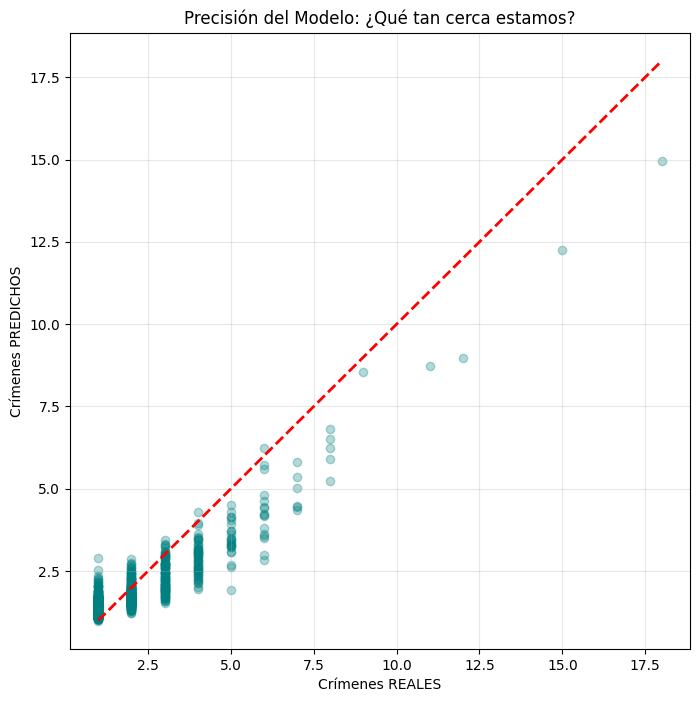

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Definir datos (Idealmente usa un set de test separado, aquí usaremos df_daily)
X_test = df_daily[features]
y_true = df_daily["crime_count"]

# 2. Predecir
y_pred = model.predict(X_test)

# 3. Métricas Numéricas
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred) # Qué tanto explicamos la varianza

print("--- Evaluación de Desempeño ---")
print(f"RMSE (Error típico): {rmse:.4f}")
print(f"MAE (Error absoluto medio): {mae:.4f}")
print(f"R2 Score: {r2:.4f} (Máximo es 1.0)")

# 4. Gráfico de Dispersión (Real vs Predicho)
# Si el modelo fuera perfecto, todos los puntos estarían en la línea diagonal roja
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.3, color="teal")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel("Crímenes REALES")
plt.ylabel("Crímenes PREDICHOS")
plt.title("Precisión del Modelo: ¿Qué tan cerca estamos?")
plt.grid(True, alpha=0.3)
plt.show()